In [28]:
from pprint import pprint
import kerchunk.hdf
import fsspec

import numpy as np
import xarray as xr
import rioxarray

from shapely.geometry import Point
import pandas as pd
import geopandas

In [2]:
%%time
NOAA_AT_NSIDC_URL = "https://noaadata.apps.nsidc.org/NOAA"
dataset = "G02156"
file_format = "netcdf"
resolution = "4km"

url = "/".join([NOAA_AT_NSIDC_URL, dataset, file_format, resolution])

fs = fsspec.filesystem("https")
filelist = [f for f in fs.find(url) if f.endswith("nc.gz")]  # to make sure we get only datafiles
print(len(filelist))
pprint(filelist[:10])

7303
['https://noaadata.apps.nsidc.org/NOAA/G02156/netcdf/4km/2004/ims2004056_4km_v1.2.nc.gz',
 'https://noaadata.apps.nsidc.org/NOAA/G02156/netcdf/4km/2004/ims2004057_4km_v1.2.nc.gz',
 'https://noaadata.apps.nsidc.org/NOAA/G02156/netcdf/4km/2004/ims2004058_4km_v1.2.nc.gz',
 'https://noaadata.apps.nsidc.org/NOAA/G02156/netcdf/4km/2004/ims2004059_4km_v1.2.nc.gz',
 'https://noaadata.apps.nsidc.org/NOAA/G02156/netcdf/4km/2004/ims2004060_4km_v1.2.nc.gz',
 'https://noaadata.apps.nsidc.org/NOAA/G02156/netcdf/4km/2004/ims2004061_4km_v1.2.nc.gz',
 'https://noaadata.apps.nsidc.org/NOAA/G02156/netcdf/4km/2004/ims2004062_4km_v1.2.nc.gz',
 'https://noaadata.apps.nsidc.org/NOAA/G02156/netcdf/4km/2004/ims2004063_4km_v1.2.nc.gz',
 'https://noaadata.apps.nsidc.org/NOAA/G02156/netcdf/4km/2004/ims2004064_4km_v1.2.nc.gz',
 'https://noaadata.apps.nsidc.org/NOAA/G02156/netcdf/4km/2004/ims2004065_4km_v1.2.nc.gz']
CPU times: user 184 ms, sys: 21.6 ms, total: 205 ms
Wall time: 3.93 s


## Trying for a single file

In [44]:
import re
import ujson

def parse_url(url):
    p = re.compile(r"ims(\d{4})(\d{3})_")
    m = p.search(url)
    if m:
        return m.groups()
    else:
        raise ValueError("No recognizable datestring to parse")

def make_json_name(url):
    year, doy = parse_url(url)
    return f"{year}_{doy}_ims_4km.json"

In [53]:
url = filelist[10]
with fsspec.open(url, compression="gzip") as infile:
    h5chunks = kerchunk.hdf.SingleHdf5ToZarr(infile, url, inline_threshold=100)
    outf = make_json_name(url)
    with open(outf, "wb") as of:
        of.write(ujson.dumps(h5chunks.translate()).encode());

In [54]:
%%time
ds = xr.open_dataset("reference://", engine="zarr", backend_kwargs={
                    "consolidated": False,
                    "storage_options": {"fo": outf, "remote_protocol": "https","remote_options": {"anon": True}}
                    })
print(ds)

<xarray.Dataset> Size: 151MB
Dimensions:             (time: 1, y: 6144, x: 6144)
Coordinates:
  * time                (time) datetime64[ns] 8B 1970-01-01
  * x                   (x) float32 25kB 2.649e+06 4.579e-41 ... 1.401e-43
  * y                   (y) float32 25kB 2.649e+06 4.579e-41 ... -9.873e-37
Data variables:
    IMS_Surface_Values  (time, y, x) float32 151MB ...
    projection          object 8B ...
Attributes: (12/49)
    Conventions:                CF-1.6, ACDD-1.3
    acknowledgment:             Produced at USNIC with support from NOAA NESD...
    cdm_data_type:              Grid
    comment:                    The IMS product has changed versions and reso...
    contributor_name:           U.S. National Ice Center, NOAA at NSIDC, NOAA...
    contributor_role:           Producer, Publisher, Advisor, Software Develo...
    ...                         ...
    summary:                    This file contains a map of snow cover and ic...
    time_coverage_duration:     P1D
   

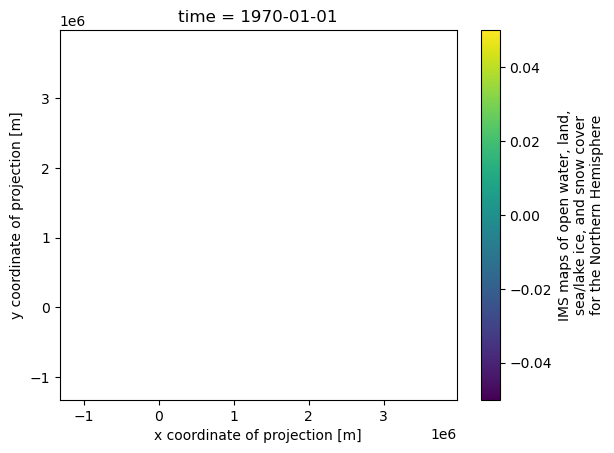

In [55]:
ds.IMS_Surface_Values.squeeze().plot.imshow(interpolation='none')

In [52]:
ds.IMS_Surface_Values.min()

<xarray.DataArray 'IMS_Surface_Values' ()> Size: 4B
array(nan, dtype=float32)

In [60]:
with fs.open(url, compression="gzip") as f:
    ds = xr.open_dataset(f, decode_coords="all")
    ds.to_zarr(url.split("/")[-1].replace("nc.gz", "zarr"))

In [63]:
zds = xr.open_dataset("ims2004066_4km_v1.2.zarr", decode_coords="all", engine="zarr")

In [64]:
zds

<xarray.Dataset> Size: 151MB
Dimensions:             (time: 1, y: 6144, x: 6144)
Coordinates:
    projection          |S1 1B ...
  * time                (time) datetime64[ns] 8B 2004-03-06
  * x                   (x) float32 25kB -1.229e+07 -1.228e+07 ... 1.229e+07
  * y                   (y) float32 25kB -1.229e+07 -1.228e+07 ... 1.229e+07
Data variables:
    IMS_Surface_Values  (time, y, x) float32 151MB ...
Attributes: (12/49)
    Conventions:                CF-1.6, ACDD-1.3
    acknowledgment:             Produced at USNIC with support from NOAA NESD...
    cdm_data_type:              Grid
    comment:                    The IMS product has changed versions and reso...
    contributor_name:           U.S. National Ice Center, NOAA at NSIDC, NOAA...
    contributor_role:           Producer, Publisher, Advisor, Software Develo...
    ...                         ...
    summary:                    This file contains a map of snow cover and ic...
    time_coverage_duration:     P1D
    time_coverage_end:          2004-03-05T23:59:59Z
    time_coverage_resolution:   P1D
    time_coverage_start:        2004-03-05T00:00:00Z
    title:                      NOAA/NESDIS Interactive Multisensor Snow and ...

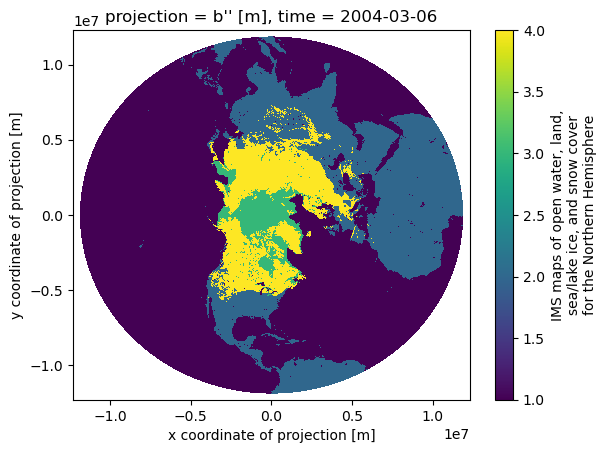

In [65]:
zds.IMS_Surface_Values.squeeze().plot.imshow(interpolation="none")

## For multiple files

In [3]:
%%time
# so = dict(
#     default_fill_cache=False, default_cache_type='first'
# )
singles = []
for u in [f for f in filelist if "/2023/" in f]:
    with fs.open(u, compression="gzip") as inf:
        h5chunks = kerchunk.hdf.SingleHdf5ToZarr(inf, u, inline_threshold=100)
        singles.append(h5chunks.translate())

CPU times: user 13.3 s, sys: 917 ms, total: 14.2 s
Wall time: 1min 28s


In [4]:
%%time
from kerchunk.combine import MultiZarrToZarr
mzz = MultiZarrToZarr(
    singles,
    remote_protocol="https",
    # remote_options={'anon': True},
    concat_dims=["time"]
)

out = mzz.translate()

CPU times: user 3.38 s, sys: 364 ms, total: 3.74 s
Wall time: 26.9 s


In [35]:
%%time
ds = xr.open_dataset(
    "reference://", engine="zarr",
    backend_kwargs={
        "storage_options": {
            "fo": out,
            "remote_protocol": "https",
            # "remote_options": {"anon": True}
        },
        "consolidated": False
    },
    # decode_times=False,
    # use_cftime=True,
)
# # do analysis...
# ds.velocity.mean()
ds

ValueError: Failed to decode variable 'time': unable to decode time units 'seconds since 1970-01-01T00:00:00Z' with 'the default calendar'. Try opening your dataset with decode_times=False or installing cftime if it is not installed.

In [31]:
ds.time.encoding

{'chunks': (319,),
 'preferred_chunks': {'time': 319},
 'compressor': Zstd(level=1),
 'filters': None,
 'dtype': dtype('uint64')}

del ds.time.attrs["time_origin"]


ds.time.attrs["units"] = ds.time.attrs["units"].replace("T", " ").replace("Z", "")
ds.time.attrs["calendar"] = "gregorian"

In [32]:
ds["time"] = ds.time.astype(np.int64)
ds.time.encoding

{}

In [34]:
ds = xr.decode_cf(ds, use_cftime=True)

ValueError: Failed to decode variable 'time': unable to decode time units 'seconds since 1970-01-01T00:00:00Z' with 'the default calendar'. Try opening your dataset with decode_times=False or installing cftime if it is not installed.

In [20]:
import cftime